In [1]:
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler
from sklearn.model_selection import (
    StratifiedShuffleSplit,
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
)
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_squared_log_error,
    accuracy_score,
)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_pandas import CategoricalImputer

# from sklearn.feature_selection import SelectKBest, chi2

<IPython.core.display.Javascript object>

In [19]:
housing_train_data = pd.read_csv("data/housing_train.csv")
housing_test_data = pd.read_csv("data/housing_test.csv")

<IPython.core.display.Javascript object>

In [4]:
housing_test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


<IPython.core.display.Javascript object>

In [20]:
X_train_numeric = housing_train_data.select_dtypes(exclude="object")
X_train_cat = housing_train_data.select_dtypes(include="object")

X_test_numeric = housing_test_data.select_dtypes(exclude="object")
X_test_cat = housing_test_data.select_dtypes(include="object")

print(
    "Numeric shape: {}, Categorical shape: {}".format(
        X_train_numeric.shape, X_train_cat.shape
    )
)

Numeric shape: (1460, 38), Categorical shape: (1460, 43)


<IPython.core.display.Javascript object>

In [21]:
X_train_numeric.drop(["Id"], inplace=True, axis=1)
numeric_corrmat = X_train_numeric.corr()

numeric_corrmat_top = numeric_corrmat.index[abs(numeric_corrmat["SalePrice"]) > 0.5]

<IPython.core.display.Javascript object>

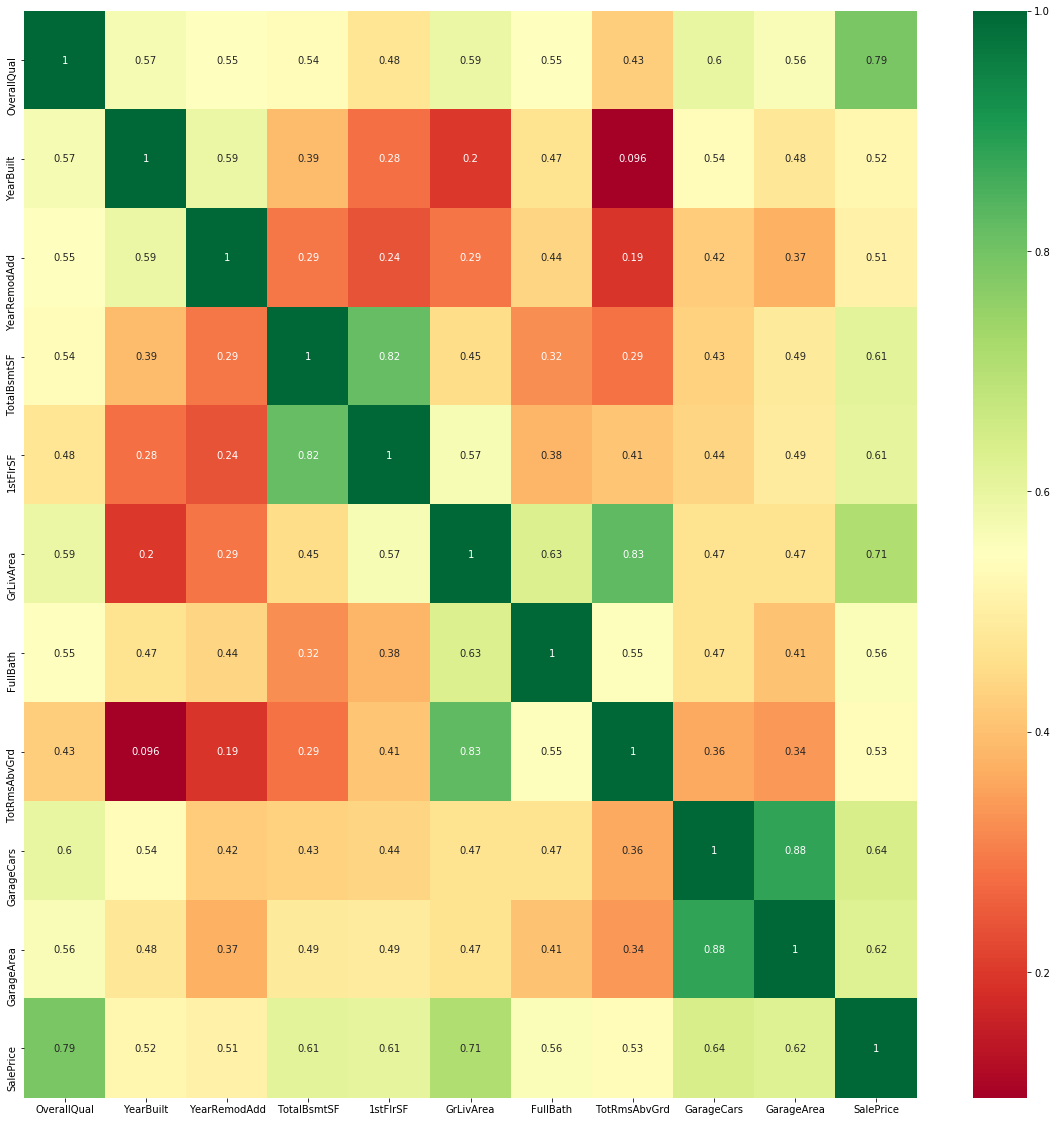

<IPython.core.display.Javascript object>

In [22]:
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(X_train_numeric[numeric_corrmat_top].corr(), annot=True, cmap="RdYlGn")

- Following attributes are correlated with `SalePrice` (positively or negatively)

```python

['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea']

```

- There is some correlation among these attributes as well 

In [24]:
X = housing_train_data.drop("SalePrice", axis=1)
y = housing_train_data.SalePrice

num_cols = X.select_dtypes(exclude="object").columns
cat_cols = X.select_dtypes(include="object").columns

print("Numeric: {}, \n\nCategorical: {}".format(num_cols, cat_cols))

Numeric: Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object'), 

Categorical: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       

<IPython.core.display.Javascript object>

In [34]:
numeric_cols_subset = numeric_corrmat_top.drop(["SalePrice"])

<IPython.core.display.Javascript object>

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=X.Neighborhood
)

<IPython.core.display.Javascript object>

In [26]:
print("Dataset size - \n\nX_train: {}, X_test: {}".format(X_train.shape, X_test.shape))

Dataset size - 

X_train: (1168, 80), X_test: (292, 80)


<IPython.core.display.Javascript object>

In [27]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.attribute_names].values

<IPython.core.display.Javascript object>

- `numeric_cols_subset` uses a subset of numeric features
- `num_cols` uses the entire set of numeric features (better MAE)

In [35]:
numeric_pipeline = Pipeline(
    steps=[
        ("selector", DataFrameSelector(numeric_cols_subset)),
        ("imputer", Imputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)
categorical_pipeline = Pipeline(
    steps=[
        ("selector", DataFrameSelector(cat_cols)),
        ("imputer", CategoricalImputer()),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)
custom_preprocessing_pipeline = FeatureUnion(
    transformer_list=[
        ("categorical_pipeline", categorical_pipeline),
        ("numeric_pipeline", numeric_pipeline),
    ]
)

/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>

In [36]:
X_train_processed = pd.DataFrame(custom_preprocessing_pipeline.fit_transform(X_train))
X_test_processed = pd.DataFrame(custom_preprocessing_pipeline.transform(X_test))

<IPython.core.display.Javascript object>

In [37]:
model_xgb = XGBRegressor()
param_dist = {"learning_rate": [0.02, 0.05, 0.1], "n_estimators": range(100, 550, 50)}

random_search = RandomizedSearchCV(
    model_xgb, param_distributions=param_dist, scoring="neg_mean_squared_error", cv=5
)

random_search.fit(X_train_processed, y_train)

print("Best parameters: {}".format(random_search.best_params_))
xgb = random_search.best_estimator_

/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:43:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/saileshg/sailspace/dev2019/py3env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:44:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters: {'n_estimators': 500, 'learning_rate': 0.05}


<IPython.core.display.Javascript object>

In [38]:
X_test_processed.head()

,0,1,2,3,4,5,6,7,8,9,...,258,259,260,261,262,263,264,265,266,267
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,-1.519144,-1.454784,-1.688867,-1.198323,-1.639170,-1.894330,-1.034846,-1.545027,-1.034080,-1.094552
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.392029,1.090840,0.976411,0.440244,0.270330,-0.468029,0.771881,-0.308582,0.304950,-0.209621
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.063557,0.198219,0.491815,0.604991,0.966316,2.584522,0.771881,2.782531,0.304950,0.670653
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,-1.519144,-0.793583,-1.688867,-2.356005,-1.251661,-1.147855,-1.034846,-2.163249,-2.373111,-2.212360
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,-0.063557,-2.016804,-1.688867,-0.085166,-0.650003,0.786887,0.771881,1.546086,-1.034080,-0.163046


<IPython.core.display.Javascript object>

In [39]:
predictions = xgb.predict(X_test_processed)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
msle = mean_squared_log_error(y_test, predictions)

print("Metrics: \n\nmae={}, \nmse={}, \nmsle={}".format(mae, mse, msle))

Metrics: 

mae=16708.316727311645, 
mse=1115811851.7949767, 
msle=0.019414082477657798


<IPython.core.display.Javascript object>

In [40]:
X_new = pd.DataFrame(custom_preprocessing_pipeline.transform(housing_test_data))

X_new.shape

(1459, 268)

<IPython.core.display.Javascript object>

In [41]:
predictions_new = xgb.predict(X_new)

<IPython.core.display.Javascript object>

In [42]:
# Save test predictions to file
output = pd.DataFrame({"Id": housing_test_data.Id, "SalePrice": predictions_new})
output.to_csv("data/submission.csv", index=False)

<IPython.core.display.Javascript object>

In [43]:
output.shape

(1459, 2)

<IPython.core.display.Javascript object>